# Figure 4 notebook - this focuses on ARs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
from extremeweatherbench import evaluate, calc, cases, defaults, inputs, metrics, regions, derived
sns.set_theme(style='whitegrid')
import shapely
from pathlib import Path
import multiprocessing
import xarray as xr
from matplotlib.lines import Line2D
import cartopy.crs as ccrs  # noqa: E402
import datetime

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

import src.plots.plotting_utils as plot_utils  # noqa: E402
import src.plots.results_utils as results_utils  # noqa: E402
import src.plots.atmospheric_river_utils as ar_plot_utils  # noqa: E402


In [3]:
# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()
# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources
# to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [4]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

ghcn_group_style = {'linestyle':'-', 'marker':'o', 'group':'GHCN'}
era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}

ifs_group_style = {'linestyle':'-', 'marker':'o', 'group':'IFS'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}

global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}

hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_ifs_cira_settings = {'forecast_source':'CIRA FOURv2 IFS', 'label_str': 'ForecastNet V2'} 
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_ifs_cira_settings = {'forecast_source':'CIRA GC IFS', 'label_str': 'GraphCast'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_ifs_cira_settings = {'forecast_source':'CIRA PANG IFS', 'label_str': 'Pangu Weather'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 

fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | ifs_group_style
gc_ifs_settings = gc_ifs_cira_settings | gc_style | ifs_group_style
pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | ifs_group_style
hres_settings = hres_ifs_settings | hres_style | hres_group_style

fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | gfs_group_style
gc_gfs_settings = gc_gfs_cira_settings | gc_style | gfs_group_style
pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | gfs_group_style


In [5]:
# load the results back in
fourv2_ar_results = pd.read_pickle(basepath + 'saved_data/fourv2_ar_results.pkl')
pang_ar_results = pd.read_pickle(basepath + 'saved_data/pang_ar_results.pkl')
hres_ar_results = pd.read_pickle(basepath + 'saved_data/hres_ar_results.pkl')
gc_ar_results = pd.read_pickle(basepath + 'saved_data/gc_ar_results.pkl')


In [6]:
fourv2_gfs_era5_settings_csi = fourv2_gfs_cira_settings | fourv2_style | era5_group_style   
gc_gfs_era5_settings_csi  = gc_gfs_cira_settings | gc_style | era5_group_style
pangu_gfs_era5_settings_csi = pangu_gfs_cira_settings | pangu_style | era5_group_style
hres_era5_settings_csi = hres_ifs_settings | hres_style | hres_group_style

# grab the ar CSI results
fourv2_ar_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz')
gc_ar_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz')
pangu_ar_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz')
hres_ar_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_era5_settings_csi['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz')

# plot the results
ar_data_csi = [fourv2_ar_plot_csi, gc_ar_plot_csi, pangu_ar_plot_csi, hres_ar_plot_csi]
ar_settings_csi = [fourv2_gfs_era5_settings_csi, gc_gfs_era5_settings_csi, 
    pangu_gfs_era5_settings_csi, hres_era5_settings_csi]

# grab the spatial displacement results
fourv2_ar_plot_sd = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='spatial_displacement', init_time='zeroz')
gc_ar_plot_sd = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='spatial_displacement', init_time='zeroz')
pangu_ar_plot_sd  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='spatial_displacement', init_time='zeroz')
hres_ar_plot_sd = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_era5_settings_csi['forecast_source'], 
    target_source='ERA5', metric='spatial_displacement', init_time='zeroz')

ar_data_sd = [fourv2_ar_plot_sd, gc_ar_plot_sd, pangu_ar_plot_sd, hres_ar_plot_sd]
ar_settings_sd = [fourv2_gfs_era5_settings_csi, gc_gfs_era5_settings_csi, 
    pangu_gfs_era5_settings_csi, hres_era5_settings_csi]

# grab the early signal results
# fourv2_ar_plot_es = pp.subset_results_to_xarray(results_df=fourv2_ar_results, 
#     forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
#     target_source='ERA5', metric='EarlySignal', init_time='zeroz')
# gc_ar_plot_es = pp.subset_results_to_xarray(results_df=gc_ar_results, 
#     forecast_source=gc_gfs_cira_settings['forecast_source'], 
#     target_source='ERA5', metric='EarlySignal', init_time='zeroz')
# pangu_ar_plot_es  = pp.subset_results_to_xarray(results_df=pang_ar_results, 
#     forecast_source=pangu_gfs_cira_settings['forecast_source'], 
#     target_source='ERA5', metric='EarlySignal', init_time='zeroz')
# hres_ar_plot_es = pp.subset_results_to_xarray(results_df=hres_ar_results, 
#     forecast_source=hres_era5_settings_csi['forecast_source'], 
#     target_source='ERA5', metric='EarlySignal', init_time='zeroz')

# ar_data_es = [fourv2_ar_plot_es, gc_ar_plot_es, pangu_ar_plot_es, hres_ar_plot_es]
# ar_settings_es = [fourv2_gfs_era5_settings_csi, gc_gfs_era5_settings_csi, 
#     pangu_gfs_era5_settings_csi, hres_era5_settings_csi]

In [7]:
# make the bounding boxes for the regions

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(na_bounding_box)
na_bounding_region = regions.BoundingBoxRegion(latitude_min=7, latitude_max=85, longitude_min=-172, longitude_max=-45)

# europe bounding box
eu_bounding_box = [-10, 35, 20, 70]
eu_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(eu_bounding_box)
eu_bounding_region = regions.BoundingBoxRegion(latitude_min=20, latitude_max=70, longitude_min=-10, longitude_max=35)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(au_bounding_box)
au_bounding_region = regions.BoundingBoxRegion(latitude_min=-50, latitude_max=-10, longitude_min=110, longitude_max=180)

# break the cases into different lists
na_subset = regions.RegionSubsetter(region=na_bounding_region, method='intersects').subset_case_collection(ewb_cases)
au_subset = regions.RegionSubsetter(region=au_bounding_region, method='intersects').subset_case_collection(ewb_cases)
eu_subset = regions.RegionSubsetter(region=eu_bounding_region, method='intersects').subset_case_collection(ewb_cases)
na_case_ids = [n.case_id_number for n in na_subset.cases]
au_case_ids = [n.case_id_number for n in au_subset.cases]
eu_case_ids = [n.case_id_number for n in eu_subset.cases]

print(f'North America Cases: {na_case_ids}')
print(f'Australia Cases: {au_case_ids}')
print(f'Europe Cases: {eu_case_ids}')


North America Cases: [1, 2, 3, 4, 5, 6, 27, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 84, 87, 88, 89, 95, 96, 97, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115, 118, 119, 121, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 194, 195, 196, 197, 198, 199, 200, 201, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337]
Australia Ca

In [8]:
# create a group style for the local/global plots
na_group_style = {'linestyle':'-', 'marker':'h', 'group':'North America'}
au_group_style = {'linestyle':'-', 'marker':'h', 'group':'Australia'}
eu_group_style = {'linestyle':'-', 'marker':'h', 'group':'Europe'}
# plot the results for one metric for the three AI models versus HRES
na_fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | na_group_style
na_gc_gfs_settings = gc_gfs_cira_settings | gc_style | na_group_style
na_pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | na_group_style
na_hres_settings = hres_ifs_settings | hres_style | na_group_style

au_fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | au_group_style
au_gc_gfs_settings = gc_gfs_cira_settings | gc_style | au_group_style
au_pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | au_group_style
au_hres_settings = hres_ifs_settings | hres_style | au_group_style

eu_fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | eu_group_style
eu_gc_gfs_settings = gc_gfs_cira_settings | gc_style | eu_group_style
eu_pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | eu_group_style
eu_hres_settings = hres_ifs_settings | hres_style | eu_group_style

# subset the data for the plots
na_fourv2_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)
na_gc_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)
na_pangu_severe_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)
na_hres_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)

# subset the data for the plots
au_fourv2_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)
au_gc_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)
au_pangu_severe_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)
au_hres_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)

# subset europe
eu_fourv2_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)
eu_gc_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)
eu_pangu_severe_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)
eu_hres_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)


# make a global settings so we can compare
fourv2_global_settings = fourv2_gfs_cira_settings | fourv2_style | global_group_style
pangu_global_settings = pangu_gfs_cira_settings | pangu_style | global_group_style
gc_global_settings = gc_gfs_cira_settings | gc_style | global_group_style
hres_global_settings = hres_ifs_settings | hres_style | global_group_style 

In [9]:
# load in the graphics objects
hres_graphics = pd.read_pickle(basepath + 'saved_data/hres_ar_graphics.pkl')
pangu_graphics = pd.read_pickle(basepath + 'saved_data/pang_ar_graphics.pkl')
fourv2_graphics = pd.read_pickle(basepath + 'saved_data/fourv2_ar_graphics.pkl')
gc_graphics = pd.read_pickle(basepath + 'saved_data/gc_ar_graphics.pkl')

In [10]:
def get_error_array_for_heatmap(results_array, hres_results, forecast_sources, 
    target_source, metric_strs, init_time, lead_time_days, higher_is_better_list):
    """
    This function takes in an array of results and parameters to say which results to grab and returns 
    error arrays and relative arrays for global, north america, and europe.
    """
    # now make the array for the scorecard
    global_rel_error = {}
    global_error = {}

    na_rel_error = {}
    na_error = {}

    au_rel_error = {}
    au_error = {}

    eu_rel_error = {}
    eu_error = {}


    for i, metric in enumerate(metric_strs):
        # initialize the arrays
        global_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        global_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        na_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        na_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        au_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        au_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        eu_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        eu_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        higher_is_better = higher_is_better_list[i]

        for j, results_df in enumerate(results_array):
            my_mean, my_relative_error = results_utils.compute_relative_error(results_df, 
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                higher_is_better=higher_is_better)
            global_error[metric][j, :] = my_mean
            global_rel_error[metric][j, :] = my_relative_error

            na_mean, na_relative_error = results_utils.compute_relative_error(results_df,
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                case_ids=na_case_ids, 
                higher_is_better=higher_is_better)
            na_error[metric][j, :] = na_mean
            na_rel_error[metric][j, :] = na_relative_error

            au_mean, au_relative_error = results_utils.compute_relative_error(results_df,
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                case_ids=au_case_ids, 
                higher_is_better=higher_is_better)
            au_error[metric][j, :] = au_mean
            au_rel_error[metric][j, :] = au_relative_error

            eu_mean, eu_relative_error = results_utils.compute_relative_error(results_df,
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                case_ids=eu_case_ids, 
                higher_is_better=higher_is_better)
            eu_error[metric][j, :] = eu_mean    
            eu_rel_error[metric][j, :] = eu_relative_error

    return global_error, global_rel_error, na_error, na_rel_error, au_error, au_rel_error, eu_error, eu_rel_error

# setup for the scorecard
# Grab means for each metric for each model
ar_metric_str = ['CriticalSuccessIndex', 'spatial_displacement']
ar_display_str = ['Critical Success Index', 'Spatial Displacement']
ar_metric_higher_is_better = [True, False]

lead_time_days = [1, 3, 5, 7, 10]

ar_results_array = [hres_ar_results, gc_ar_results, 
    pang_ar_results, fourv2_ar_results]
forecast_source = [hres_ifs_settings['forecast_source'], 
    gc_gfs_cira_settings['forecast_source'], 
    pangu_gfs_cira_settings['forecast_source'],
    fourv2_gfs_cira_settings['forecast_source']]

(global_ar_error, global_rel_ar_error, na_ar_error, na_rel_ar_error, 
    au_ar_error, au_rel_ar_error, eu_ar_error, eu_rel_ar_error) = \
    get_error_array_for_heatmap(ar_results_array, hres_ar_results, 
    forecast_source, 'ERA5', ar_metric_str, 'zeroz', lead_time_days, ar_metric_higher_is_better )


In [11]:
def select_ivt_and_maks(graphics_obect, lead_time_hours):
    # select the right lead time
    lead_time_td = pd.Timedelta(hours=lead_time_hours)
    ivt = graphics_obect.integrated_vapor_transport.sel(lead_time=lead_time_td, method="nearest")
    ar_mask = graphics_obect.atmospheric_river_mask.sel(lead_time=lead_time_td, method="nearest")

    # select the right valid time (hack for now to always select the first valid time)
    valid_time = graphics_obect.integrated_vapor_transport.valid_time[0]
    ivt2 = ivt.sel(valid_time=valid_time, method="nearest")
    ar_mask2 = ar_mask.sel(valid_time=valid_time, method="nearest")
    return ivt2, ar_mask2


(32, 39.0)
plotting the cases for each event type


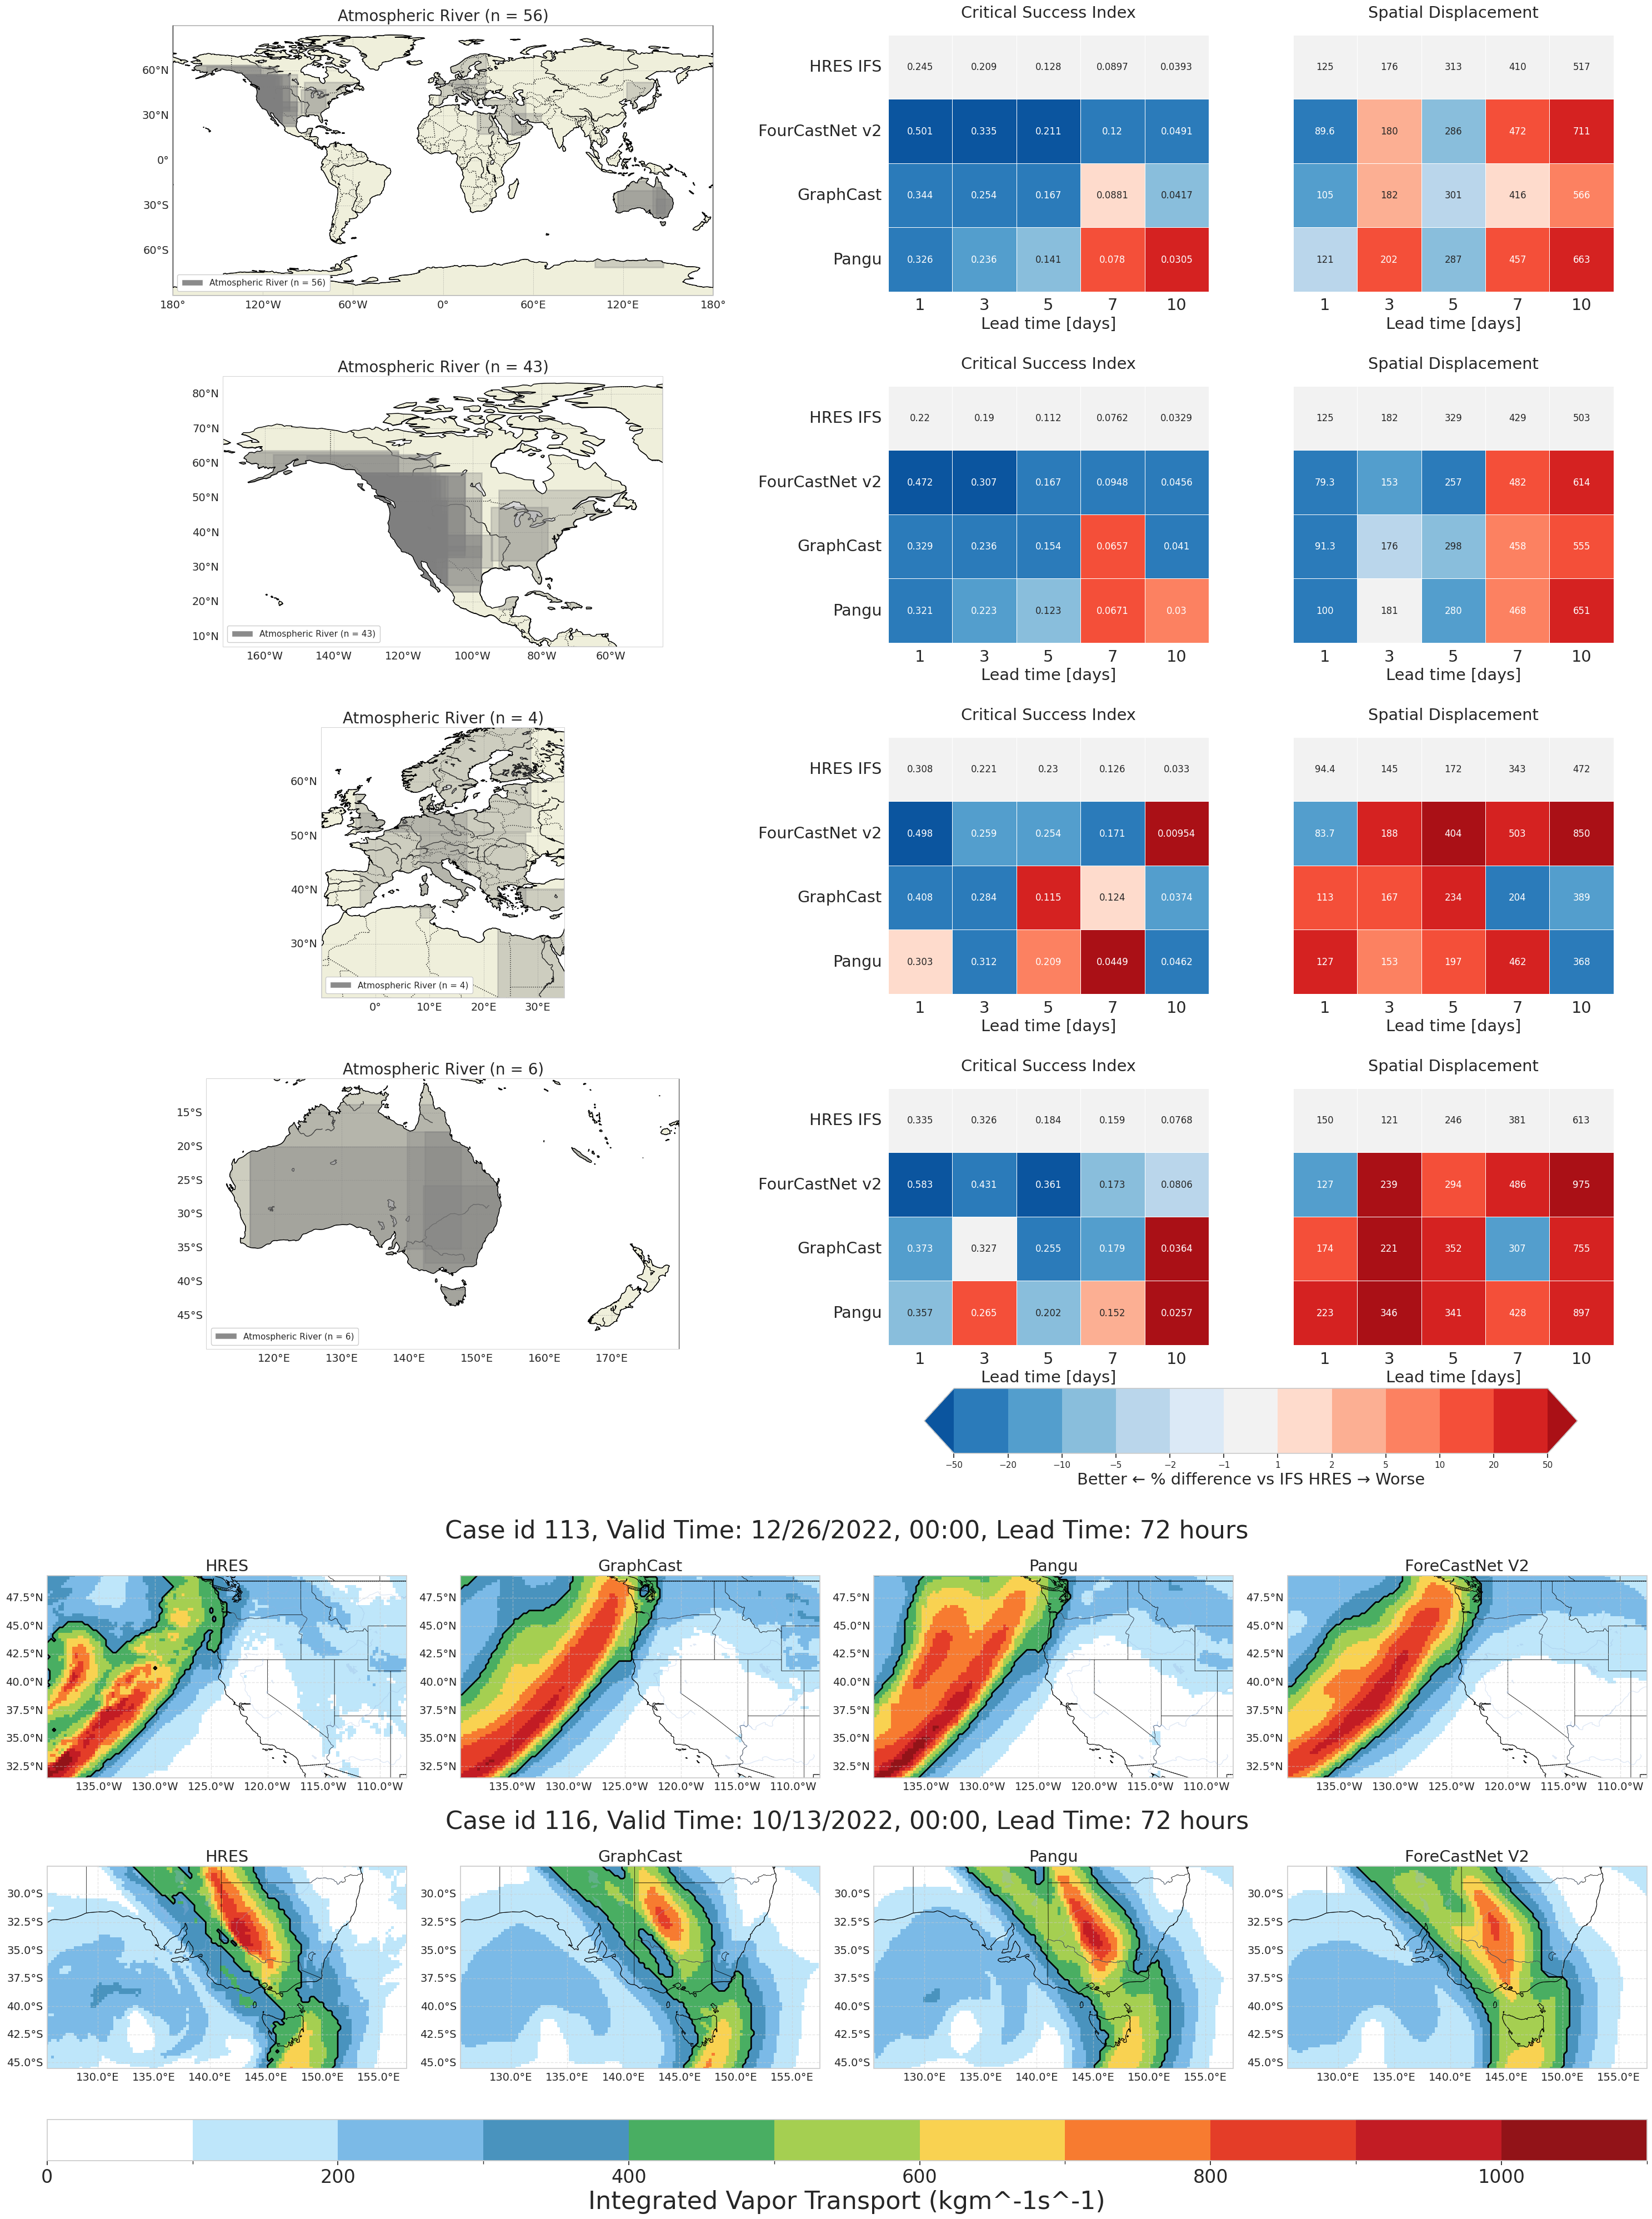

In [12]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

n_rows_top = 4
n_rows_bottom = 2
n_rows = n_rows_top + n_rows_bottom
n_cols_top = 2  # Columns for top 3 rows
n_cols_bottom = 4  # Columns for bottom 2 rows (more Cartopy plots)
figsize = (8 * max(n_cols_top, n_cols_bottom), 6.5 * n_rows)
print(figsize)

# Create figure first
fig = plt.figure(figsize=figsize)

# Main GridSpec: 6 rows, use max columns for layout
# Top 4 rows will use 2 columns, bottom 2 rows will use 4 columns
gs_main = GridSpec(n_rows, 1, figure=fig, left=0.05, right=0.95, top=0.98, bottom=0.02,
    wspace=.1, hspace=1)

# Create subplots for top 4 rows (2 columns each)
gs_top = GridSpecFromSubplotSpec(n_rows_top, n_cols_top, subplot_spec=gs_main[0:n_rows_top, 0],
                                  wspace=0.02, hspace=0.3,
                                  width_ratios=[1, 1])

# Create subplots for bottom 2 rows (4 columns each - all Cartopy)
gs_bottom = GridSpecFromSubplotSpec(n_rows_bottom, n_cols_bottom, subplot_spec=gs_main[n_rows_top:n_rows, 0],
                                     wspace=0.15, hspace=0.05)

# Create all subplots - initialize as array with shape (n_rows, max_cols)
max_cols = max(n_cols_top, n_cols_bottom)
axs = np.empty((n_rows, max_cols), dtype=object)

# Top n_rows_top rows: 2 columns (Cartopy on left, regular on right)
for i in range(n_rows_top):
    # Left column: Cartopy
    ax_cartopy = fig.add_subplot(gs_top[i, 0], projection=ccrs.PlateCarree())
    axs[i,0] = ax_cartopy

    # Right column: Regular matplotlib
    ax_regular = fig.add_subplot(gs_top[i, 1])
    axs[i,1] = ax_regular

# Bottom n_rows_bottom rows: 4 columns (all Cartopy)
for i in range(n_rows_bottom):
    for j in range(n_cols_bottom):
        ax_cartopy = fig.add_subplot(gs_bottom[i, j], projection=ccrs.PlateCarree())
        axs[i+n_rows_top,j] = ax_cartopy


# the left hand column of figure one shows all of the cases for each event type
# plot the cases for each event type
print("plotting the cases for each event type")
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="atmospheric_river",
    fill_boxes=True,
    ax=axs[0, 0],
)
# plot the cases for north america
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="atmospheric_river",
    bounding_box=na_bounding_box,
    fill_boxes=True,
    ax=axs[1, 0],
)

# plot the cases for europe
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="atmospheric_river",
    bounding_box=eu_bounding_box,
    fill_boxes=True,
    ax=axs[2, 0],
)
# plot the cases for australia
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="atmospheric_river",
    bounding_box=au_bounding_box,
    fill_boxes=True,
    ax=axs[3, 0],
)

# plot the heatmaps for each of the subareas
ar_settings = {}
ar_settings["subplot_titles"] = ar_display_str
ar_settings["metric_str"] = ar_metric_str
ar_settings["lead_time_days"] = lead_time_days
ar_settings["model_order"] = ["HRES IFS", "FourCastNet v2", "GraphCast", "Pangu"]

# second column of figure 2 shows the scorecard
plot_utils.plot_heatmap(
    global_rel_ar_error,
    global_ar_error,
    ar_settings,
    ax=axs[0, 1],
)

plot_utils.plot_heatmap(
    na_rel_ar_error,
    na_ar_error,
    ar_settings,
    ax=axs[1, 1],
)

plot_utils.plot_heatmap(
    eu_rel_ar_error,
    eu_ar_error,
    ar_settings,
    ax=axs[2, 1],
)

plot_utils.plot_heatmap(
    au_rel_ar_error,
    au_ar_error,
    ar_settings,
    ax=axs[3, 1],
    show_colorbar=True,
)

# now plot the ar case studies
my_id = 113
lead_time_hours = 72
hres_ivt, hres_ar_mask = select_ivt_and_maks(hres_graphics[my_id], lead_time_hours)
gc_ivt, gc_ar_mask = select_ivt_and_maks(gc_graphics[my_id], lead_time_hours)
pangu_ivt, pangu_ar_mask = select_ivt_and_maks(pangu_graphics[my_id], lead_time_hours)
fourv2_ivt, fourv2_ar_mask = select_ivt_and_maks(fourv2_graphics[my_id], lead_time_hours)

# setup a four panel subplot with cartopy subfigures using GridSpec
ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=hres_ivt, ar_mask=hres_ar_mask, 
    title="HRES", ax=axs[4,0], colorbar=False)

ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=gc_ivt, ar_mask=gc_ar_mask, 
    title="GraphCast", ax=axs[4,1], colorbar=False)

ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=pangu_ivt, ar_mask=pangu_ar_mask, 
    title="Pangu", ax=axs[4,2], colorbar=False)

ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=fourv2_ivt, ar_mask=fourv2_ar_mask, 
    title="ForeCastNet V2", ax=axs[4,3], colorbar=False)

# put a title on the 5th row
# Get the position from row 5 axes to position title above it
# Use the first axes in row 5 to get position (now that it's been plotted)
ax_row5 = axs[4, 0]
pos_row5 = ax_row5.get_position()
# Position title above row 5, centered
# get_position returns a Bbox in figure coordinates (0-1)
title_y_fig = pos_row5.y1 + 0.015  # Position slightly above row 5 top edge
valid_time = hres_graphics[my_id].integrated_vapor_transport.valid_time[0].values
# convert the valid time to a datetime object
valid_time_dt = pd.to_datetime(valid_time)
# Use strftime() to format the string
valid_time_str = valid_time_dt.strftime('%m/%d/%Y, %H:%M')
fig.text(0.5, title_y_fig, f"Case id {my_id}, Valid Time: {valid_time_str}, Lead Time: {lead_time_hours} hours", 
         size=32, ha='center', va='bottom', transform=fig.transFigure)


# now plot the ar case studies
my_id = 116
lead_time_hours = 72
hres_ivt, hres_ar_mask = select_ivt_and_maks(hres_graphics[my_id], lead_time_hours)
gc_ivt, gc_ar_mask = select_ivt_and_maks(gc_graphics[my_id], lead_time_hours)
pangu_ivt, pangu_ar_mask = select_ivt_and_maks(pangu_graphics[my_id], lead_time_hours)
fourv2_ivt, fourv2_ar_mask = select_ivt_and_maks(fourv2_graphics[my_id], lead_time_hours)

# setup a four panel subplot with cartopy subfigures using GridSpec
ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=hres_ivt, ar_mask=hres_ar_mask, 
    title="HRES", ax=axs[5,0], colorbar=False)

ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=gc_ivt, ar_mask=gc_ar_mask, 
    title="GraphCast", ax=axs[5,1], colorbar=False)

ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=pangu_ivt, ar_mask=pangu_ar_mask, 
    title="Pangu", ax=axs[5,2], colorbar=False)

ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=fourv2_ivt, ar_mask=fourv2_ar_mask, 
    title="ForeCastNet V2", ax=axs[5,3], colorbar=False)

# put a title on the 5th row
# Get the position from row 5 axes to position title above it
# Use the first axes in row 5 to get position (now that it's been plotted)
ax_row5 = axs[5, 0]
pos_row5 = ax_row5.get_position()
# Position title above row 5, centered
# get_position returns a Bbox in figure coordinates (0-1)
title_y_fig = pos_row5.y1 + 0.015  # Position slightly above row 5 top edge
valid_time = hres_graphics[my_id].integrated_vapor_transport.valid_time[0].values
# convert the valid time to a datetime object
valid_time_dt = pd.to_datetime(valid_time)
# Use strftime() to format the string
valid_time_str = valid_time_dt.strftime('%m/%d/%Y, %H:%M')
fig.text(0.5, title_y_fig, f"Case id {my_id}, Valid Time: {valid_time_str}, Lead Time: {lead_time_hours} hours", 
         size=32, ha='center', va='bottom', transform=fig.transFigure)

# show the colorbar below the bottom row (row 5)
# Create a ScalarMappable for the colorbar
from matplotlib.cm import ScalarMappable
cmap, norm = ar_plot_utils.setup_atmospheric_river_colormap_and_levels()
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array, we just need the colormap/norm

# Get the position from row 5 (bottom row) subplots to position colorbar below them
pos0 = gs_bottom[1, 0].get_position(fig)
pos3 = gs_bottom[1, 3].get_position(fig)
# Create axes below row 5 that spans all 4 columns
# Position it just below row 5, using a small height
cbar_y = pos0.y0 - pos0.height * 0.2  # Position below row 5
cbar_height = pos0.height * 0.15  # Height for colorbar
cbar_ax = fig.add_axes([pos0.x0, cbar_y, pos3.x1 - pos0.x0, cbar_height])

# Add horizontal colorbar below bottom row
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Integrated Vapor Transport (kgm^-1s^-1)", size=32)
cbar.ax.tick_params(labelsize=24)

#fig.savefig(basepath + "saved_data/figure4.png", dpi=600, bbox_inches="tight")